In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from logger import logger
import os
import cv2
import pydot
import tensorflow as tf
#-------------------------------------------------
import keras.backend as K
from keras.applications import inception_v3, inception_resnet_v2
from keras import callbacks as Kcallbacks
from keras.utils import plot_model
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Input, Activation, ZeroPadding2D, BatchNormalization,\
    Flatten, MaxPooling2D, Dropout, concatenate, AveragePooling2D
#-------------------------------------------------------------------------
from tensorflow import losses as tflosses
%matplotlib inline
np.random.seed(0)

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
train = np.load('./data/train/train_dataset.npy')
labels = np.load('./data/train/labels.npy')
print (train.shape, labels.shape, sep=' - ')

(1604, 75, 75, 4) - (1604, 1)


In [2]:
def prepare_test_data() :
    test_dataset = np.load('./data/test/test_dataset.npy')
    test_ids = np.load('./data/test/ids.npy')
    print (test_dataset.shape, test_ids.shape, sep=' - ')
    return test_dataset, test_ids

In [4]:
def get_more_images(imgs, epoches):
    
    more_images = []
    rotated_imgs = []
    for e in range(epoches) :
        for i in range(0,imgs.shape[0]):
            a=imgs[i,:,:,0]
            b=imgs[i,:,:,1]
            c=imgs[i,:,:,2]
            d=imgs[i,:,:,3]
            
            scale = np.random.random(1) * .6 + 1
            M = cv2.getRotationMatrix2D( (a.shape[0]/2,a.shape[1]/2), np.random.randint(0,360), scale)

            a1 = cv2.warpAffine(a, M, a.shape)
            b1 = cv2.warpAffine(b, M, a.shape)
            c1 = cv2.warpAffine(c, M, a.shape)
            d1 = cv2.warpAffine(d, M, a.shape)
            
            rotated_imgs.append(np.dstack((a1,b1,c1,d1)))
            
            
    r = np.array(rotated_imgs)
       
    more_images = np.concatenate((imgs,r))
    
    return more_images

e = 1
train_ext = get_more_images(train, e)
labels_ext = np.concatenate([labels for i in range(e+1)])
print (train_ext.shape, labels_ext.shape, sep=' - ')

(3208, 75, 75, 4) - (3208, 1)


In [5]:
# getting validation set
train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(train_ext, labels_ext,
                                                                            test_size=.0000001,shuffle=True)


print (train_dataset.shape, train_labels.shape, sep=' - ')
print (valid_dataset.shape, valid_labels.shape, sep=' - ')

del train, labels, train_ext, labels_ext

(3207, 75, 75, 4) - (3207, 1)
(1, 75, 75, 4) - (1, 1)


------------------------

 ** A ship


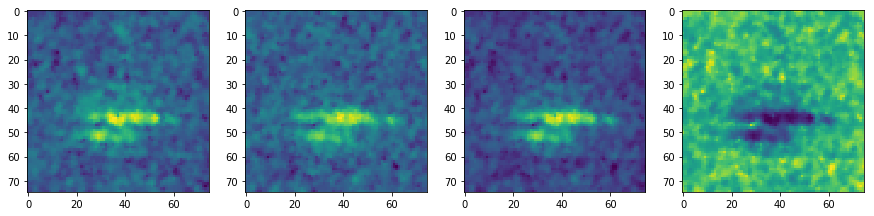

In [6]:
plt.rcParams["figure.figsize"] = [15,15]
index = np.random.randint(0, train_dataset.shape[0])
f, axarr = plt.subplots(1,train_dataset.shape[3])
for i in range(train_dataset.shape[3]):
    _ = axarr[i].imshow(train_dataset[index,:,:,i])

print (" ** A ship" if train_labels[index,0] == 1 else " ** An iceberg")

In [ ]:
train_dataset = train_dataset[:,:,:,[2,3]]

In [8]:
def convolution_layer(X, layer_name, paddings, convC, convF, convS, poolF, poolS, droprate=.2):
    #X = ZeroPadding2D(paddings, name='Zero_Padding_'+layer_name)(X)
    X = Conv2D(convC, convF, strides=convS, padding='SAME', name='Conv2d_'+layer_name)(X)
    X = BatchNormalization(axis=3, name='BN_'+layer_name)(X)
    X = Activation('relu', name='relu_activ_'+layer_name)(X)
    X = MaxPooling2D(poolF, poolS, padding='SAME', name='MaxPooling_'+layer_name)(X)
    X = Dropout(droprate, name='dropout_'+layer_name)(X)
    return X
#--------------------------------------------------------
def fullyconnected_layer(X, layer_name, dense_units, activ, droprate=.2):
    X = Dense(dense_units, activation=activ, name='Dense_'+layer_name)(X)
    if layer_name == 'output' : return X
    X = BatchNormalization( name='BN_'+layer_name)(X)
    X = Dropout(droprate, name='dropout_'+layer_name)(X)
    return X
#-----------------------------------------------------------------------
def get_model(input_shape):
    X_input = Input(input_shape, name= 'input')
    # layer 1
    X = convolution_layer(X_input, 'layer1', 2, 64,   5, 2, 3, 2, .2)
    X = convolution_layer(X,       'layer2', 2, 64,  5, 2, 3, 2, .2)
    X = convolution_layer(X,       'layer3', 2, 128,  3, 2, 3, 2, .2)
    X = convolution_layer(X,       'layer4', 2, 128,  2, 1, 3, 2, .2)
    #-*-*-*-*-*-**-*-*-*-*-*-*-*
    X = Flatten()(X)
    #X = fullyconnected_layer(X, 'FC1', 512, 'relu', .5)
    X = fullyconnected_layer(X, 'FC2', 256, 'relu', .5)
    X = fullyconnected_layer(X, 'FC3', 256, 'relu', .5)
    X = fullyconnected_layer(X, 'output', 1, 'sigmoid')
    
    model = Model(inputs=X_input, outputs=X)
    return model
model = get_model([75,75,4])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 75, 75, 4)         0         
_________________________________________________________________
Conv2d_layer1 (Conv2D)       (None, 38, 38, 64)        6464      
_________________________________________________________________
BN_layer1 (BatchNormalizatio (None, 38, 38, 64)        256       
_________________________________________________________________
relu_activ_layer1 (Activatio (None, 38, 38, 64)        0         
_________________________________________________________________
MaxPooling_layer1 (MaxPoolin (None, 19, 19, 64)        0         
_________________________________________________________________
dropout_layer1 (Dropout)     (None, 19, 19, 64)        0         
_________________________________________________________________
Conv2d_layer2 (Conv2D)       (None, 10, 10, 64)        102464    
__________

In [9]:
model.compile(Adam(lr=.001), loss='binary_crossentropy',metrics=[])

In [10]:
callbacks = [ 
    Kcallbacks.EarlyStopping(patience=20, verbose=1, mode='min'),
    Kcallbacks.History(),
    Kcallbacks.CSVLogger('./tmp/keras/checkpoints/4/logger3.log', append=True),
    Kcallbacks.ReduceLROnPlateau(factor=.1, patience=10, verbose=1),
    Kcallbacks.ModelCheckpoint('./tmp/keras/checkpoints/4/ckpt3-{val_loss:.4f}-{epoch:02d}.hdf5',
                               verbose=1, save_best_only=1, mode='min')
] 

model.fit(x=train_dataset, y=train_labels, batch_size=32, epochs=100, shuffle=True, verbose=1, 
          validation_split=.2, callbacks=callbacks)

Train on 2565 samples, validate on 642 samples
Epoch 1/100
2565/2565 [==============================] - 40s 15ms/step - loss: 0.8168 - val_loss: 0.7972
Epoch 2/100
2565/2565 [==============================] - 40s 15ms/step - loss: 0.6452 - val_loss: 0.5849
Epoch 3/100
2565/2565 [==============================] - 34s 13ms/step - loss: 0.5630 - val_loss: 0.4391
Epoch 4/100
2565/2565 [==============================] - 34s 13ms/step - loss: 0.5221 - val_loss: 0.4910
Epoch 5/100
2565/2565 [==============================] - 34s 13ms/step - loss: 0.4316 - val_loss: 0.4158
Epoch 6/100
2565/2565 [==============================] - 34s 13ms/step - loss: 0.3955 - val_loss: 0.3340
Epoch 7/100
2565/2565 [==============================] - 34s 13ms/step - loss: 0.4115 - val_loss: 0.3472
Epoch 8/100
2565/2565 [==============================] - 34s 13ms/step - loss: 0.3752 - val_loss: 0.3578
Epoch 9/100
2565/2565 [==============================] - 34s 13ms/step - loss: 0.3583 - val_loss: 0.3825
Epoch 10

Epoch 37/100
2565/2565 [==============================] - 33s 13ms/step - loss: 0.2260 - val_loss: 0.3653
Epoch 38/100
2565/2565 [==============================] - 33s 13ms/step - loss: 0.2147 - val_loss: 0.3301
Epoch 39/100
2565/2565 [==============================] - 33s 13ms/step - loss: 0.1979 - val_loss: 0.3933
Epoch 40/100
2565/2565 [==============================] - 33s 13ms/step - loss: 0.2067 - val_loss: 0.3832
Epoch 41/100
2565/2565 [==============================] - 34s 13ms/step - loss: 0.2109 - val_loss: 0.3673
Epoch 42/100
2560/2565 [============================>.] - ETA: 0s - loss: 0.1941
Epoch 00042: reducing learning rate to 1.0000000474974514e-05.
Epoch 00042: val_loss did not improve
2565/2565 [==============================] - 33s 13ms/step - loss: 0.1937 - val_loss: 0.3609
Epoch 43/100
2565/2565 [==============================] - 33s 13ms/step - loss: 0.2083 - val_loss: 0.3628
Epoch 44/100
2565/2565 [==============================] - 33s 13ms/step - loss: 0.1908 - 

In [ ]:
model.evaluate(train_dataset, train_labels)

In [ ]:
best_model.evaluate(train_dataset[2500:2700], train_labels[2500:2700])

In [7]:
def predict_test_dataset(model, subid):
    test_data, test_ids = prepare_test_data()
    #test_data = test_data[:,:,:,[2,3]]
    test_preds = model.predict(test_data, batch_size=200, verbose=1)
    sub_df = pd.DataFrame({'id':test_ids, 'is_iceberg':test_preds.reshape((-1))})
    sub_df.to_csv('./tmp/keras/checkpoints/5/submission-{}'.format(subid), index=False)

In [8]:
predict_test_dataset(best_model, '.0877')

(8424, 75, 75, 4) - (8424,)
8424/8424 [==============================] - 1441s 171ms/step


In [3]:
best_model = load_model('./tmp/keras/checkpoints/5/ckpt2-0.0877-36.hdf5',
                        custom_objects={'log_loss':tflosses.log_loss})

In [ ]:
plot_model(best_model, to_file='./model.png')

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

------------------------------------

In [ ]:
X_input = Input([75,75,4], name='X_input')
model = inception_v3.InceptionV3(input_tensor=X_input, pooling='max', classes=1, weights=None)

In [ ]:
inc_model.summary()